### Loan Classification

In [14]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedGroupKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error, r2_score

In [3]:
df = pd.read_csv("final_queried_data.csv")
df.head(10)

,ID,CD_Account,Education,Personal_Loan,CCAvg,Mortgage,Age,Income
0,1,0,1,0,1.6,0,25,49
1,2,0,1,0,1.5,0,45,34
2,3,0,1,0,1.0,0,39,11
3,4,0,2,0,1.3,0,35,100
4,5,0,2,0,1.0,0,35,45
5,6,0,2,0,0.4,155,37,29
6,7,0,2,0,1.5,0,53,72
7,8,0,3,0,0.3,0,50,22
8,9,0,2,0,0.6,104,35,81
9,10,0,3,1,8.9,0,34,180


In [3]:
df.size

40000

In [4]:
df.isnull().sum()

ID               0
CD_Account       0
Education        0
Personal_Loan    0
CCAvg            0
Mortgage         0
Age              0
Income           0
dtype: int64

In [5]:
df.dtypes

ID                 int64
CD_Account         int64
Education          int64
Personal_Loan      int64
CCAvg            float64
Mortgage           int64
Age                int64
Income             int64
dtype: object

In [6]:
X = df.drop('Personal_Loan', axis=1)
y = df['Personal_Loan']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

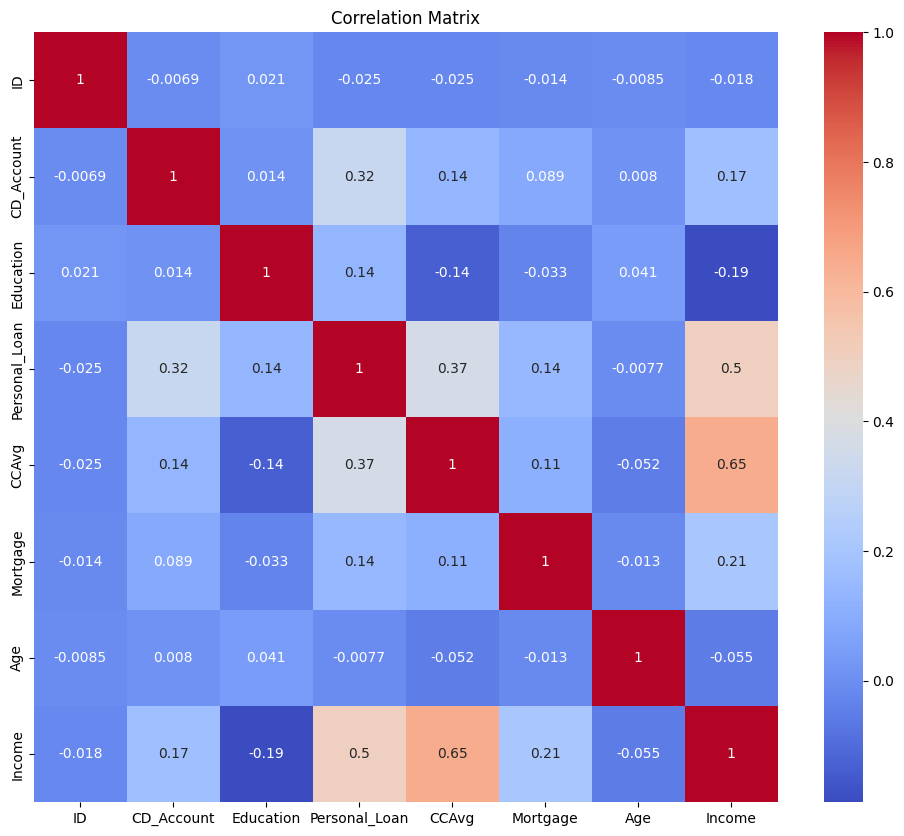

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [8]:
print(df['Personal_Loan'].value_counts(normalize=True))

Personal_Loan
0    0.904
1    0.096
Name: proportion, dtype: float64


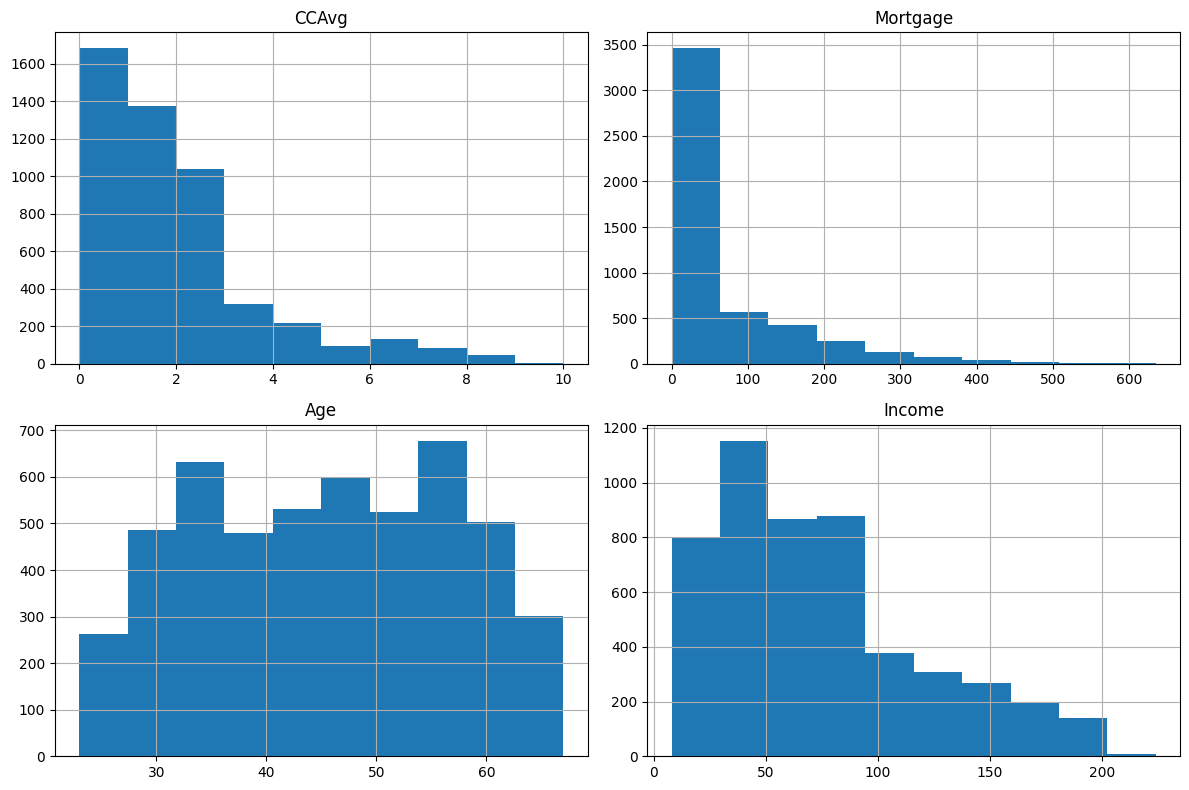

In [9]:
continuous_vars = ['CCAvg', 'Mortgage', 'Age', 'Income']
df[continuous_vars].hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [10]:
print("Train set distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))

Train set distribution:
Personal_Loan
0    0.904
1    0.096
Name: proportion, dtype: float64

Test set distribution:
Personal_Loan
0    0.904
1    0.096
Name: proportion, dtype: float64


## The observations that I made are: 
### 1. Need to check for duplicates
### 2. No need to cap the values the highest values are at their natural state 
### 3. Need to address the imbalance in the target variable --> the personal loan column is showed as imbalanced, but it is okay because the no. of people having loan is less than that of the people having loans taken, it is much natural to be this way. 
### 4. There were no missing values as the data was properly filled already 
### 5. the Nan values are filled using fillna() --> df.mean() was used for this! 
### apart from all this there were no other observations, the data was all good for the rest of the procedures to be followed

In [11]:

num_duplicates = df.duplicated().sum()
num_duplicates

np.int64(0)

In [6]:
df.isnull().sum()

ID               0
CD_Account       0
Education        0
Personal_Loan    0
CCAvg            0
Mortgage         0
Age              0
Income           0
dtype: int64

In [14]:
pip install -q dagshub mlflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import dagshub
dagshub.init(repo_owner='SomeshBhandarkar', repo_name='LoanClassificationProject', mlflow=True)

Accessing as SomeshBhandarkar

Initialized MLflow to track repo "SomeshBhandarkar/LoanClassificationProject"

Repository SomeshBhandarkar/LoanClassificationProject initialized!

In [3]:
import mlflow
import mlflow.sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [20]:
X = df.drop(['ID', 'Personal_Loan'], axis=1)
y = df['Personal_Loan']

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

In [25]:
mlflow.set_tracking_uri("https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow")
mlflow.set_experiment("Experiment 1: logistic_regression_experiment")

2024/12/14 21:29:03 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 1: logistic_regression_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/7bcb5f777d76414c8f88e5e5391fdc79', creation_time=1734229742599, experiment_id='2', last_update_time=1734229742599, lifecycle_stage='active', name='Experiment 1: logistic_regression_experiment', tags={}>

In [26]:
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1')
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'saga']},
             scoring='f1')

## CROSS VALIDATION TECHNIQUE --> 
### Dual Cross-Validation Strategy
###   -> The code uses two different CV approaches for specific purposes:
###   1. CV-3 for Hyperparameter Tuning
####    -> Used with GridSearchCV for hyperparameter optimization
####    -> Fewer folds reduce computational cost during the intensive parameter search
####    -> Provides a good balance between training time and model validation
###    2. CV-10 for Final Model Evaluation
####    -> Used to evaluate the model with best parameters
####    -> More folds provide a more robust estimate of model performance
####    -> Reduces variance in performance estimates
####    -> Gives better insight into model's generalization ability
####    -> This dual approach optimizes both computational efficiency during tuning and statistical reliability in final evaluation.

In [27]:
with mlflow.start_run():
    mlflow.log_params(grid_search.best_params_)

    cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=10, scoring='f1')

    mlflow.log_metric("cv_f1_mean", cv_scores.mean())
    mlflow.log_metric("cv_f1_std", cv_scores.std())

    grid_search.best_estimator_.fit(X, y)
    y_pred = grid_search.best_estimator_.predict(X)

    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)

    mlflow.sklearn.log_model(grid_search.best_estimator_, "model")

print("------------------------------------------------------------")
print("Best parameters:", grid_search.best_params_)
print("Mean CV F1-score:", cv_scores.mean())
print("Std CV F1-score:", cv_scores.std())
print("F1-score on whole data:", f1)
print("Confusion matrix:", [tn, fp, fn, tp])

2024/12/14 21:29:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rare-wren-530 at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/2/runs/84d226d7f1bd4c6c863adbe6717b8813
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/2
------------------------------------------------------------
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Mean CV F1-score: 0.675907405167753
Std CV F1-score: 0.05407989232639325
F1-score on whole data: 0.6770708283313326
Confusion matrix: [np.int64(4449), np.int64(71), np.int64(198), np.int64(282)]


## Experiment 2 --> 

In [28]:
pipelines = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression())
    ]),
    'RidgeClassifier': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RidgeClassifier())
    ]),
    'RandomForestClassifier': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier())
    ]),
    'XGBClassifier': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier())
    ])
}

In [29]:
param_grids = {
    'LogisticRegression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    },
    'RidgeClassifier': {
        'classifier__alpha': [0.1, 1.0, 10.0],
        'classifier__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'RandomForestClassifier': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'XGBClassifier': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.3]
    }
}

In [ ]:
mlflow.set_tracking_uri("https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow")
mlflow.set_experiment("Experiment 2: Multiple Classifiers")

2024/12/14 21:34:19 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 2: Multiple Classifiers' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/df78203ba9c842248499744b95c427ac', creation_time=1734230058605, experiment_id='3', last_update_time=1734230058605, lifecycle_stage='active', name='Experiment 2: Multiple Classifiers', tags={}>

In [33]:
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error, r2_score
for clf_name, pipeline in pipelines.items():
    with mlflow.start_run(run_name=clf_name):
        grid_search = GridSearchCV(pipeline, param_grids[clf_name], cv=3, scoring='f1')
        grid_search.fit(X_train, y_train)
        
        mlflow.log_params(grid_search.best_params_)

        y_pred = grid_search.predict(X_test)
        y_pred_train = grid_search.predict(X_train)

        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("true_positives", tp)
        mlflow.log_metric("true_negatives", tn)
        mlflow.log_metric("false_positives", fp)
        mlflow.log_metric("false_negatives", fn)
        mlflow.log_metric("r2_train", r2_train)
        mlflow.log_metric("r2_test", r2_test)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)

        cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=10, scoring='f1')

        mlflow.log_metric("cv_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv_f1_std", cv_scores.std())

        mlflow.sklearn.log_model(grid_search.best_estimator_, "model")
        
        print(f"\nResults for {clf_name}:")
        print("Best parameters:", grid_search.best_params_)
        print("Mean CV F1-score:", cv_scores.mean())
        print("Std CV F1-score:", cv_scores.std())
        print("F1-score on test data:", f1)
        print("Confusion matrix:", [tn, fp, fn, tp])
        print("R² score (train):", r2_train)
        print("R² score (test):", r2_test)
        print("MSE:", mse)
        print("RMSE:", rmse)
        print("-" * 50)

2024/12/14 21:49:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for LogisticRegression:
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Mean CV F1-score: 0.6680763414890099
Std CV F1-score: 0.05538817072285303
F1-score on test data: 0.7052023121387283
Confusion matrix: [np.int64(888), np.int64(16), np.int64(35), np.int64(61)]
R² score (train): 0.3921690634218289
R² score (test): 0.4123340707964601
MSE: 0.051
RMSE: 0.22583179581272428
--------------------------------------------------
🏃 View run LogisticRegression at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/3/runs/b52989a2b94d44ef97188af3b5fbad26
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/3


2024/12/14 21:50:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for RidgeClassifier:
Best parameters: {'classifier__alpha': 0.1, 'classifier__solver': 'auto'}
Mean CV F1-score: 0.47591046742279997
Std CV F1-score: 0.06879731371389858
F1-score on test data: 0.3709677419354839
Confusion matrix: [np.int64(899), np.int64(5), np.int64(73), np.int64(23)]
R² score (train): 0.20780328171091433
R² score (test): 0.10121681415929196
MSE: 0.078
RMSE: 0.2792848008753788
--------------------------------------------------
🏃 View run RidgeClassifier at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/3/runs/c8caba0f1ef7461eb2f70c88cdb2dbba
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/3


2024/12/14 21:50:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for RandomForestClassifier:
Best parameters: {'classifier__max_depth': 30, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Mean CV F1-score: 0.8259409954309114
Std CV F1-score: 0.04109290795918442
F1-score on test data: 0.850828729281768
Confusion matrix: [np.int64(896), np.int64(8), np.int64(19), np.int64(77)]
R² score (train): 0.9971192846607669
R² score (test): 0.6888827433628318
MSE: 0.027
RMSE: 0.16431676725154984
--------------------------------------------------
🏃 View run RandomForestClassifier at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/3/runs/f64c314064e246cca5235d1f9a3f73aa
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/3


2024/12/14 21:51:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for XGBClassifier:
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Mean CV F1-score: 0.8403642848556115
Std CV F1-score: 0.04707775826878988
F1-score on test data: 0.8648648648648649
Confusion matrix: [np.int64(895), np.int64(9), np.int64(16), np.int64(80)]
R² score (train): 0.8444413716814159
R² score (test): 0.7119284660766961
MSE: 0.025
RMSE: 0.15811388300841897
--------------------------------------------------
🏃 View run XGBClassifier at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/3/runs/f11c059211c84729810a6208448d1137
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/3


### Experiment 3: 

In [19]:
def create_features(df):

    df['Age_Income_Ratio'] = df['Age'] / df['Income']
    df['CCAvg_Income_Ratio'] = df['CCAvg'] / df['Income']
    df['Mortgage_Income_Ratio'] = df['Mortgage'] / df['Income']

    df['Age_Squared'] = df['Age'] ** 2
    df['Income_Squared'] = df['Income'] ** 2
    df['CCAvg_Squared'] = df['CCAvg'] ** 2
    
    return df

In [20]:
data = create_features(df)
X = data.drop(['ID', 'Personal_Loan'], axis=1)
y = data['Personal_Loan']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [40]:
pipelines = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression())
    ]),
    'RidgeClassifier': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RidgeClassifier())
    ]),
    'RandomForestClassifier': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier())
    ]),
    'XGBClassifier': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier())
    ])
}

In [41]:
param_grids = {
    'LogisticRegression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    },
    'RidgeClassifier': {
        'classifier__alpha': [0.1, 1.0, 10.0],
        'classifier__solver': ['auto', 'svd', 'cholesky']
    },
    'RandomForestClassifier': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5]
    },
    'XGBClassifier': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1]
    }
}

In [42]:
mlflow.set_tracking_uri("https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow")
mlflow.set_experiment("Experiment 3 - Feature_Engineering")

for clf_name, pipeline in pipelines.items():
    with mlflow.start_run(run_name=f"{clf_name}_FeatureEngineering"):
        mlflow.log_param("features_created", [
            "Age_Income_Ratio", "CCAvg_Income_Ratio", "Mortgage_Income_Ratio",
            "Age_Squared", "Income_Squared", "CCAvg_Squared"
        ])

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        y_pred_train = pipeline.predict(X_train)

        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        r2_test = r2_score(y_test, y_pred)
        r2_train = r2_score(y_train, y_pred_train)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("true_positives", tp)
        mlflow.log_metric("true_negatives", tn)
        mlflow.log_metric("false_positives", fp)
        mlflow.log_metric("false_negatives", fn)
        mlflow.log_metric("r2_train", r2_train)
        mlflow.log_metric("r2_test", r2_test)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)

        if clf_name in ['RandomForestClassifier', 'XGBClassifier']:
            feature_importance = pipeline.named_steps['classifier'].feature_importances_
            for feat, imp in zip(X.columns, feature_importance):
                mlflow.log_metric(f"importance_{feat}", imp)

        mlflow.sklearn.log_model(pipeline, "model")
        
        print(f"\nResults for {clf_name}:")
        print("F1-score:", f1)
        print("Confusion matrix:", [tn, fp, fn, tp])
        print("R² score (train):", r2_train)
        print("R² score (test):", r2_test)
        print("MSE:", mse)
        print("RMSE:", rmse)
        print("-" * 50)

2024/12/15 01:11:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for LogisticRegression:
F1-score: 0.7849462365591398
Confusion matrix: [np.int64(887), np.int64(8), np.int64(32), np.int64(73)]
R² score (train): 0.4968275862068966
R² score (test): 0.5743548816174514
MSE: 0.04
RMSE: 0.2
--------------------------------------------------
🏃 View run LogisticRegression_FeatureEngineering at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/4/runs/9a2c13f17d5b45819896d5a598bdaf63
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/4


2024/12/15 01:11:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for RidgeClassifier:
F1-score: 0.5324675324675324
Confusion matrix: [np.int64(887), np.int64(8), np.int64(64), np.int64(41)]
R² score (train): 0.17020689655172416
R² score (test): 0.23383878691141258
MSE: 0.072
RMSE: 0.2683281572999748
--------------------------------------------------
🏃 View run RidgeClassifier_FeatureEngineering at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/4/runs/2b7c029212bc4deea2957cdd23496f15
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/4


2024/12/15 01:11:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for RandomForestClassifier:
F1-score: 0.9090909090909091
Confusion matrix: [np.int64(892), np.int64(3), np.int64(15), np.int64(90)]
R² score (train): 1.0
R² score (test): 0.8084596967278531
MSE: 0.018
RMSE: 0.1341640786499874
--------------------------------------------------
🏃 View run RandomForestClassifier_FeatureEngineering at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/4/runs/569f56393fe2483ab14ee717cbbcd215
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/4


2024/12/15 01:12:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for XGBClassifier:
F1-score: 0.8787878787878788
Confusion matrix: [np.int64(889), np.int64(6), np.int64(18), np.int64(87)]
R² score (train): 1.0
R² score (test): 0.7446129289704708
MSE: 0.024
RMSE: 0.15491933384829668
--------------------------------------------------
🏃 View run XGBClassifier_FeatureEngineering at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/4/runs/52d7ca64f07f49ef9db7b248fce7c096
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/4


## Experiment 4 -> 

In [21]:
X = df.drop(['ID', 'Personal_Loan'], axis=1)
y = df['Personal_Loan']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
import mlflow
import mlflow.sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
mlflow.set_tracking_uri("https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow")
mlflow.set_experiment("Experiment 4 - Feature_Selection")

2024/12/15 23:24:14 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 4 - Feature_Selection' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/41b68707a14e4c6191eaa04ad5a0199c', creation_time=1734323053531, experiment_id='6', last_update_time=1734323053531, lifecycle_stage='active', name='Experiment 4 - Feature_Selection', tags={}>

In [13]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

In [14]:
pipelines = {
    'Correlation_Threshold': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=4)),
        ('classifier', XGBClassifier(random_state=42))
    ]),
    'Feature_Importance': Pipeline([
        ('selector', SelectKBest(score_func=f_classif, k=3)),
        ('classifier', XGBClassifier(random_state=42))
    ]),
    'Variance_Threshold': Pipeline([
        ('selector', VarianceThreshold(threshold=0.1)),
        ('classifier', XGBClassifier(random_state=42))
    ])
}

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1]
}

In [17]:
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error, r2_score
for method_name, pipeline in pipelines.items():
    with mlflow.start_run(run_name=f"{method_name}_Selection"):
        pipeline.fit(X_train, y_train)

        if method_name != 'Variance_Threshold':
            selected_mask = pipeline.named_steps['selector'].get_support()
        else:
            selected_mask = pipeline.named_steps['selector'].get_support()
        
        selected_features = X.columns[selected_mask].tolist()

        y_pred = pipeline.predict(X_test)
        y_pred_train = pipeline.predict(X_train)

        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        r2_test = r2_score(y_test, y_pred)
        r2_train = r2_score(y_train, y_pred_train)

        mlflow.log_param("selected_features", selected_features)
        mlflow.log_param("n_selected_features", len(selected_features))
        
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("true_positives", tp)
        mlflow.log_metric("true_negatives", tn)
        mlflow.log_metric("false_positives", fp)
        mlflow.log_metric("false_negatives", fn)
        mlflow.log_metric("r2_train", r2_train)
        mlflow.log_metric("r2_test", r2_test)

        feature_importance = pipeline.named_steps['classifier'].feature_importances_
        for feat, imp in zip(selected_features, feature_importance):
            mlflow.log_metric(f"importance_{feat}", imp)

        mlflow.sklearn.log_model(pipeline, "model")
        
        print(f"\nResults for {method_name}:")
        print(f"Selected Features: {selected_features}")
        print(f"F1-score: {f1:.4f}")
        print(f"Confusion Matrix: [TN={tn}, FP={fp}, FN={fn}, TP={tp}]")
        print(f"R2 Score (train): {r2_train:.4f}")
        print(f"R2 Score (test): {r2_test:.4f}")
        print("-" * 50)

        importances = pd.DataFrame({
            'feature': selected_features,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        
        mlflow.log_param("top_feature", importances.iloc[0]['feature'])
        mlflow.log_metric("top_feature_importance", importances.iloc[0]['importance'])

2024/12/16 00:04:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for Correlation_Threshold:
Selected Features: ['CD_Account', 'CCAvg', 'Mortgage', 'Income']
F1-score: 0.6073
Confusion Matrix: [TN=867, FP=28, FN=47, TP=58]
R2 Score (train): 0.8293
R2 Score (test): 0.2019
--------------------------------------------------
🏃 View run Correlation_Threshold_Selection at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/6/runs/c38bf53f31d5475eb3feef42077fc827
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/6


2024/12/16 00:04:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for Feature_Importance:
Selected Features: ['CD_Account', 'CCAvg', 'Income']
F1-score: 0.5926
Confusion Matrix: [TN=867, FP=28, FN=49, TP=56]
R2 Score (train): 0.7970
R2 Score (test): 0.1806
--------------------------------------------------
🏃 View run Feature_Importance_Selection at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/6/runs/d201212f17e94a33b2a14b9f50e51080
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/6


2024/12/16 00:05:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for Variance_Threshold:
Selected Features: ['CD_Account', 'Education', 'CCAvg', 'Mortgage', 'Age', 'Income']
F1-score: 0.8768
Confusion Matrix: [TN=886, FP=9, FN=16, TP=89]
R2 Score (train): 1.0000
R2 Score (test): 0.7340
--------------------------------------------------
🏃 View run Variance_Threshold_Selection at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/6/runs/c415d6ff550848b88268db87d5bd5b6b
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/6


### Experiment 5 --> 

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [23]:
X = df.drop(['ID', 'Personal_Loan'], axis=1)
y = df['Personal_Loan']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [22]:
mlflow.set_tracking_uri("https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow")
mlflow.set_experiment("Experiment 5 - PCA ")

2024/12/16 00:41:33 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 5 - PCA ' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/f43828d2a36645d082644e9510da06cc', creation_time=1734327693647, experiment_id='7', last_update_time=1734327693647, lifecycle_stage='active', name='Experiment 5 - PCA ', tags={}>

In [25]:
with mlflow.start_run(run_name="PCA_Analysis"):
    pca = PCA()
    X_pca_train = pca.fit_transform(X_train)
    X_pca_test = pca.transform(X_test)

    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-')
    plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'ro-')
    plt.xlabel('Principal Components')
    plt.ylabel('Variance Explained')
    plt.title('Scree Plot')
    plt.grid(True)
    plt.legend(['Individual Variance', 'Cumulative Variance'])
    plt.savefig('scree_plot.png')
    plt.close()

    mlflow.log_param("n_components", len(explained_variance))
    for i, var in enumerate(explained_variance):
        mlflow.log_metric(f"variance_ratio_pc{i+1}", var)
        mlflow.log_metric(f"cumulative_variance_pc{i+1}", cumulative_variance[i])

    n_components = np.argmax(cumulative_variance >= 0.95) + 1

    pca_final = PCA(n_components=n_components)
    X_train_reduced = pca_final.fit_transform(X_train)
    X_test_reduced = pca_final.transform(X_test)

    clf = LogisticRegression(random_state=42)
    clf.fit(X_train_reduced, y_train)

    y_pred = clf.predict(X_test_reduced)
    y_pred_train = clf.predict(X_train_reduced)

    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)

    mlflow.log_param("selected_components", n_components)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)
    mlflow.log_metric("r2_train", r2_train)
    mlflow.log_metric("r2_test", r2_test)

    mlflow.log_artifact("scree_plot.png")

    mlflow.sklearn.log_model(clf, "model")
    
    print(f"Number of components selected: {n_components}")
    print(f"Cumulative variance explained: {cumulative_variance[n_components-1]:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Confusion Matrix: [TN={tn}, FP={fp}, FN={fn}, TP={tp}]")
    print(f"R2 Score (train): {r2_train:.4f}")
    print(f"R2 Score (test): {r2_test:.4f}")

2024/12/16 00:42:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Number of components selected: 6
Cumulative variance explained: 1.0000
F1-score: 0.7111
Confusion Matrix: [TN=884, FP=11, FN=41, TP=64]
R2 Score (train): 0.3674
R2 Score (test): 0.4467
🏃 View run PCA_Analysis at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/7/runs/5ee2a26f9d9c46799c7f0b1d1f0cf849
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/7


## Experiment 6 -> Custom experiment: in this experiment 6, perform t-sne on the and give me the code for it, and make a visuallization plot for it and log the results in MLFlow

In [24]:
from sklearn.manifold import TSNE
df = pd.read_csv("final_queried_data.csv")
X = df.drop(['ID', 'Personal_Loan'], axis=1)
y = df['Personal_Loan']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.isnull().sum()

CD_Account    0
Education     0
CCAvg         0
Mortgage      0
Age           0
Income        0
dtype: int64

In [9]:
mlflow.set_tracking_uri("https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow")
mlflow.set_experiment("Experiment 6 - TSNE and Visualization")

2024/12/17 01:28:51 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 6 - TSNE and Visualization' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/6f525b4f2bbb422f9cdafdd0405ed9af', creation_time=1734416930455, experiment_id='9', last_update_time=1734416930455, lifecycle_stage='active', name='Experiment 6 - TSNE and Visualization', tags={}>

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
with mlflow.start_run(run_name="TSNE_Analysis"):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_train_tsne = tsne.fit_transform(X_train)
    X_test_tsne = tsne.fit_transform(X_test)

    train_tsne_df = pd.DataFrame(data=X_train_tsne, columns=['TSNE1', 'TSNE2'])
    train_tsne_df['Personal_Loan'] = y_train
    train_tsne_df['Set'] = 'Train'
    
    test_tsne_df = pd.DataFrame(data=X_test_tsne, columns=['TSNE1', 'TSNE2'])
    test_tsne_df['Personal_Loan'] = y_test
    test_tsne_df['Set'] = 'Test'

    tsne_df = pd.concat([train_tsne_df, test_tsne_df])

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', 
                    hue='Personal_Loan', style='Set',
                    palette='viridis', alpha=0.6)
    plt.title('t-SNE Visualization of Loan Data (Train and Test Sets)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')

    plt.savefig('tsne_plot.png')
    plt.close()

    mlflow.log_param("perplexity", 30)
    mlflow.log_param("n_iter", 1000)
    mlflow.log_param("n_components", 2)
    mlflow.log_param("train_size", X_train.shape[0])
    mlflow.log_param("test_size", X_test.shape[0])

    train_kl_divergence = tsne.kl_divergence_
    mlflow.log_metric("train_kl_divergence", train_kl_divergence)

    train_loan_groups = train_tsne_df.groupby('Personal_Loan')
    train_centers = train_loan_groups[['TSNE1', 'TSNE2']].mean()
    
    train_inter_cluster_dist = np.linalg.norm(
        train_centers.loc[0] - train_centers.loc[1]
    )
    mlflow.log_metric("train_inter_cluster_distance", train_inter_cluster_dist)

    test_loan_groups = test_tsne_df.groupby('Personal_Loan')
    test_centers = test_loan_groups[['TSNE1', 'TSNE2']].mean()
    
    test_inter_cluster_dist = np.linalg.norm(
        test_centers.loc[0] - test_centers.loc[1]
    )
    mlflow.log_metric("test_inter_cluster_distance", test_inter_cluster_dist)

    mlflow.log_artifact("tsne_plot.png")

    print("t-SNE Analysis Results:")
    print(f"Train KL Divergence: {train_kl_divergence:.4f}")
    print(f"Train Inter-cluster Distance: {train_inter_cluster_dist:.4f}")
    print(f"Test Inter-cluster Distance: {test_inter_cluster_dist:.4f}")

t-SNE Analysis Results:
Train KL Divergence: 0.5794
Train Inter-cluster Distance: 2.1957
Test Inter-cluster Distance: 3.5992
🏃 View run TSNE_Analysis at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/9/runs/f9bc2beb138b4b158cdfbcdf40929fc7
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/9


## Experiment 7 - in this experiment 7, perform recursive function elimination for better feature selection and give me the code for it, and log the results in MLFlow

In [19]:
from sklearn.feature_selection import RFE
mlflow.set_tracking_uri("https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow")
mlflow.set_experiment("Feature 7 - RFE_Feature_Selection")

2024/12/17 02:21:13 INFO mlflow.tracking.fluent: Experiment with name 'Feature 7 - RFE_Feature_Selection' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/aff77f59de3348c4ab7a5fcc7fa5bf6b', creation_time=1734420072379, experiment_id='10', last_update_time=1734420072379, lifecycle_stage='active', name='Feature 7 - RFE_Feature_Selection', tags={}>

In [21]:
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error, r2_score
feature_nums = [2, 3, 4, 5]

with mlflow.start_run(run_name="RFE_Analysis"):
    results = {}
    
    for n_features in feature_nums:
        model = XGBClassifier(random_state=42)
        rfe = RFE(estimator=model, n_features_to_select=n_features)
        rfe.fit(X_train, y_train)
        selected_features = X.columns[rfe.support_].tolist()
        X_train_rfe = rfe.transform(X_train)
        X_test_rfe = rfe.transform(X_test)
        model.fit(X_train_rfe, y_train)

        y_pred = model.predict(X_test_rfe)
        y_pred_train = model.predict(X_train_rfe)

        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        r2_test = r2_score(y_test, y_pred)
        r2_train = r2_score(y_train, y_pred_train)

        mlflow.log_param(f"selected_features_{n_features}", selected_features)
        mlflow.log_metric(f"f1_score_{n_features}", f1)
        mlflow.log_metric(f"r2_train_{n_features}", r2_train)
        mlflow.log_metric(f"r2_test_{n_features}", r2_test)
        mlflow.log_metric(f"true_positives_{n_features}", tp)
        mlflow.log_metric(f"true_negatives_{n_features}", tn)
        mlflow.log_metric(f"false_positives_{n_features}", fp)
        mlflow.log_metric(f"false_negatives_{n_features}", fn)

        results[n_features] = {
            'selected_features': selected_features,
            'f1_score': f1,
            'r2_train': r2_train,
            'r2_test': r2_test,
            'confusion_matrix': [tn, fp, fn, tp]
        }
        
        print(f"\nResults for {n_features} features:")
        print(f"Selected features: {selected_features}")
        print(f"F1-score: {f1:.4f}")
        print(f"R² score (train): {r2_train:.4f}")
        print(f"R² score (test): {r2_test:.4f}")
        print(f"Confusion Matrix: [TN={tn}, FP={fp}, FN={fn}, TP={tp}]")
        print("-" * 50)

    best_n = max(results.keys(), key=lambda x: results[x]['f1_score'])

    mlflow.log_param("best_n_features", best_n)
    mlflow.log_param("best_features", results[best_n]['selected_features'])
    mlflow.log_metric("best_f1_score", results[best_n]['f1_score'])

    final_rfe = RFE(XGBClassifier(random_state=42), n_features_to_select=best_n)
    final_rfe.fit(X_train, y_train)
    mlflow.sklearn.log_model(final_rfe, "final_model")


Results for 2 features:
Selected features: ['CD_Account', 'Education']
F1-score: 0.3750
R² score (train): -0.0534
R² score (test): 0.0423
Confusion Matrix: [TN=883, FP=12, FN=78, TP=27]
--------------------------------------------------

Results for 3 features:
Selected features: ['CD_Account', 'Education', 'Income']
F1-score: 0.8247
R² score (train): 0.6734
R² score (test): 0.6382
Confusion Matrix: [TN=886, FP=9, FN=25, TP=80]
--------------------------------------------------

Results for 4 features:
Selected features: ['CD_Account', 'Education', 'CCAvg', 'Income']
F1-score: 0.8738
R² score (train): 0.9117
R² score (test): 0.7233
Confusion Matrix: [TN=884, FP=11, FN=15, TP=90]
--------------------------------------------------

Results for 5 features:
Selected features: ['CD_Account', 'Education', 'CCAvg', 'Mortgage', 'Income']
F1-score: 0.8846
R² score (train): 0.9411
R² score (test): 0.7446
Confusion Matrix: [TN=884, FP=11, FN=13, TP=92]
-------------------------------------------

2024/12/17 02:33:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RFE_Analysis at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/10/runs/6ab19a75e0ce43b6813259f6b1108f1b
🧪 View experiment at: https://dagshub.com/SomeshBhandarkar/LoanClassificationProject.mlflow/#/experiments/10


### Create meaningful F1-score plots to compare experiments and determine the best model.

In [5]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Ridge Classifier': RidgeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

In [10]:
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error, r2_score
results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate F1 scores
    train_f1 = f1_score(y_train, y_pred_train)
    test_f1 = f1_score(y_test, y_pred_test)
    
    results[name] = {
        'Train F1': train_f1,
        'Test F1': test_f1
    }

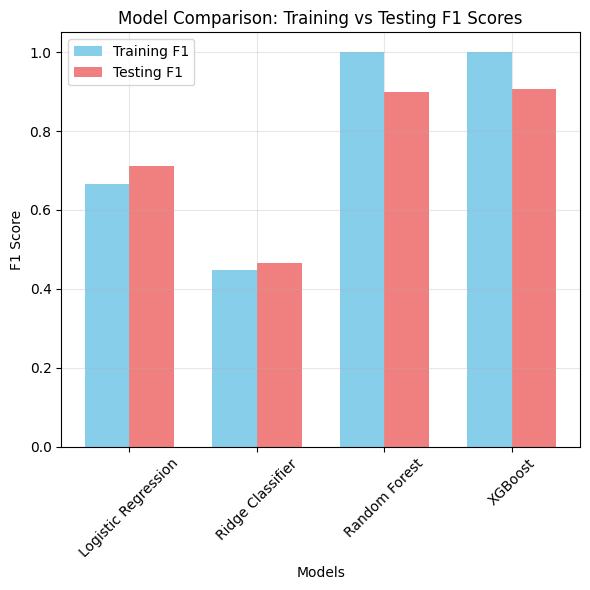

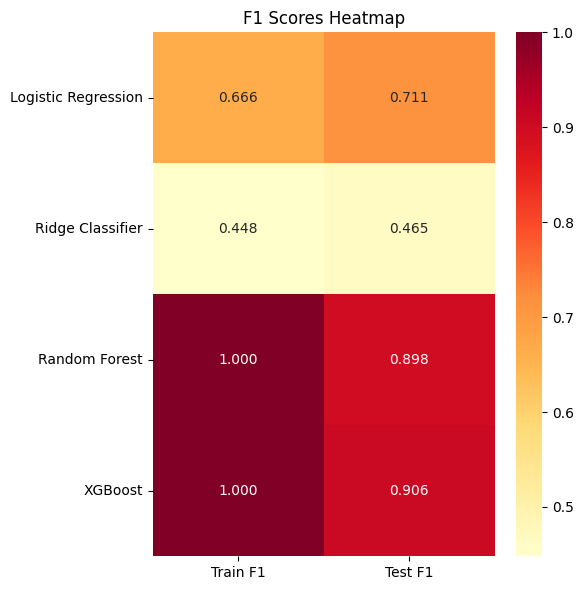


Detailed Results:

Logistic Regression:
Training F1 Score: 0.666
Testing F1 Score: 0.711

Ridge Classifier:
Training F1 Score: 0.448
Testing F1 Score: 0.465

Random Forest:
Training F1 Score: 1.000
Testing F1 Score: 0.898

XGBoost:
Training F1 Score: 1.000
Testing F1 Score: 0.906


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error, r2_score
plt.figure(figsize=(6, 6))
x = np.arange(len(models))
width = 0.35

train_scores = [results[model]['Train F1'] for model in models]
test_scores = [results[model]['Test F1'] for model in models]

plt.bar(x - width/2, train_scores, width, label='Training F1', color='skyblue')
plt.bar(x + width/2, test_scores, width, label='Testing F1', color='lightcoral')

plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Model Comparison: Training vs Testing F1 Scores')
plt.xticks(x, models.keys(), rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
scores_df = pd.DataFrame(results).T
sns.heatmap(scores_df, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('F1 Scores Heatmap')
plt.tight_layout()
plt.show()

print("\nDetailed Results:")
for model, scores in results.items():
    print(f"\n{model}:")
    print(f"Training F1 Score: {scores['Train F1']:.3f}")
    print(f"Testing F1 Score: {scores['Test F1']:.3f}")

## Save the final model using joblib.
## Create a FastAPI application to serve the model.
## Containerize the FastAPI application using Docker and push to Docker Hub.
## Deploy the containerized API to a cloud platform.

In [25]:
import joblib
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)
joblib.dump(best_model, 'RF_loan_prediction_model.pkl')

['RF_loan_prediction_model.pkl']